In [1]:
%matplotlib inline

from dataclasses import dataclass

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import yasa
from IPython.display import display
from mne import set_log_level
from neurolib.models.multimodel import MultiModel
from neurolib.utils.signal import RatesSignal
from scipy.signal import find_peaks
from yasa import get_centered_indices, stft_power

from aln_thalamus import ALNThalamusMiniNetwork
from plotting import (
    plot_average_events_ts,
    plot_circular_histogram,
    plot_kullback_leibler_modulation_index,
)
from spindle_detection import (
    event_based_so_phase_while_spindle,
    so_phase_while_spindle,
    spindles_detect_aln,
    spindles_detect_thalamus,
)
from statistical_testing import get_p_values
from utils import dummy_detect_down_states, get_amplitude, get_dummy_so_phase, get_phase
from xfreq import (
    XFreqEvaluateSignal,
    kullback_leibler_modulation_index,
    mean_vector_length,
    mutual_information,
    phase_locking_value,
)

DPI = 75
CMAP = "plasma"
plt.rcParams["figure.figsize"] = (20, 9)
plt.rcParams["font.size"] = 18
plt.style.use("default_light.mplstyle")
set_log_level("WARNING")

SAVE_FIG = True

In [2]:
POLAR_XTICKLABELS = [r"$-\pi$ = $\pi$", r"$-\pi/2$", "0", r"$\pi/2$", r"$\pi$"]
DELAY = 13.0  # ms
DURATION = 2 * 60 * 1000  # ms
OU_TAU = 5.0  # ms
DT = 0.01  # ms
SAMPLING_DT = 1.0  # ms
T_SPIN_UP = 5000  # ms
SW = {"low_freq": None, "high_freq": 3.0}
SP = {"low_freq": 12.0, "high_freq": 15.0}
CFC_DF_COLS = ["nodes", "connectivity", "measure", "value", "p-value"]


def simulate_net(
    ad_th,
    th_ad,
    ou_exc_mu,
    ou_inh_mu,
    aln_sigma=0.0,
    tcr_sigma=0.0,
    tauA=1000.0,
    b=15.0,
    a=0.0,
):
    # init model
    model = MultiModel(
        ALNThalamusMiniNetwork(
            np.array([[0.0, th_ad], [ad_th, 0.0]]),
            np.array([[0.0, DELAY], [DELAY, 0.0]]),
        )
    )
    model.params["*g_LK"] = 0.032
    model.params["ALNThlmNet.ALNNode_0.ALNMassEXC_0.a"] = a
    model.params["*b"] = b
    model.params["*tauA"] = tauA
    model.params["*EXC*mu"] = ou_exc_mu
    model.params["*INH*mu"] = ou_inh_mu
    model.params["*ALNMass*input*sigma"] = aln_sigma
    model.params["*TCR*input*sigma"] = tcr_sigma
    model.params["*input*tau"] = OU_TAU
    model.params["duration"] = DURATION + T_SPIN_UP
    model.params["dt"] = DT
    model.params["sampling_dt"] = SAMPLING_DT
    model.params["backend"] = "numba"

    model.run()

    results_df = pd.DataFrame(
        {
            "ALN": model.r_mean_EXC[0, :] * 1000.0,
            "TCR": model.r_mean_EXC[1, :] * 1000.0,
        },
        index=model.t,
    )
    results_df.index.name = "time"

    return results_df.loc[5:]


def so_phase(signal):
    return get_phase(signal, filter_args=SW, pad=5.0)
    # return get_dummy_so_phase(signal, threshold=2.0, min_down_length=0.1)


def spindle_phase(signal):
    return get_phase(signal, filter_args=SP, pad=5.0)


def spindle_amp(signal):
    return get_amplitude(signal, filter_args=SP, pad=5.0)


klmi = XFreqEvaluateSignal(
    measure_function=kullback_leibler_modulation_index,
    slow_timeseries_preprocessing=so_phase,
    fast_timeseries_preprocessing=spindle_amp,
    measure_settings={"bins": 36, "return_for_plotting": True},
    surrogate_settings={
        "num_surr": 1000,
        "surrogate_type": "IAAFT",
        "n_iterations": 10,
    },
    workers=6,
)

mvl = XFreqEvaluateSignal(
    measure_function=lambda x, y: np.abs(mean_vector_length(x, y)),
    slow_timeseries_preprocessing=so_phase,
    fast_timeseries_preprocessing=spindle_amp,
    measure_settings={},
    surrogate_settings={
        "num_surr": 1000,
        "surrogate_type": "IAAFT",
        "n_iterations": 10,
    },
    workers=6,
)

plv = XFreqEvaluateSignal(
    measure_function=lambda x, y, n, m: np.abs(phase_locking_value(x, y, n, m)),
    slow_timeseries_preprocessing=so_phase,
    fast_timeseries_preprocessing=spindle_phase,
    measure_settings={"n": 1, "m": 1},
    surrogate_settings={
        "num_surr": 1000,
        "surrogate_type": "IAAFT",
        "n_iterations": 10,
    },
    workers=6,
)

mi_eqq = XFreqEvaluateSignal(
    measure_function=mutual_information,
    slow_timeseries_preprocessing=so_phase,
    fast_timeseries_preprocessing=spindle_phase,
    measure_settings={"algorithm": "EQQ", "bins": 16},
    surrogate_settings={
        "num_surr": 1000,
        "surrogate_type": "IAAFT",
        "n_iterations": 10,
    },
    workers=6,
)


def klmi_eval(slow_ts, fast_ts, subtype="ALN vs. TCR", baseline="regular"):
    klmi_data, klmi_surrs = klmi.run(slow_timeseries=slow_ts, fast_timeseries=fast_ts)
    surrs_values = np.array([surr_result[0] for surr_result in klmi_surrs])
    p_val = get_p_values(klmi_data[0], surrs_values, tailed="upper")
    klmi_val = klmi_data[0]
    df = pd.DataFrame(
        [[subtype, baseline, "KL-MI", klmi_val, p_val]], columns=CFC_DF_COLS
    )
    return klmi_data, klmi_surrs, df


def mvl_eval(slow_ts, fast_ts, subtype="ALN vs. TCR", baseline="regular"):
    mvl_data, mvl_surrs = mvl.run(slow_timeseries=slow_ts, fast_timeseries=fast_ts)
    p_val = get_p_values(mvl_data, mvl_surrs, tailed="upper")
    df = pd.DataFrame(
        [[subtype, baseline, "MVL", mvl_data, p_val]], columns=CFC_DF_COLS
    )
    return df


def plv_eval(slow_ts, fast_ts, subtype="ALN vs. TCR", baseline="regular"):
    plv_data, plv_surrs = plv.run(slow_timeseries=slow_ts, fast_timeseries=fast_ts)
    p_val = get_p_values(plv_data, plv_surrs, tailed="upper")
    df = pd.DataFrame(
        [[subtype, baseline, "PLV", plv_data, p_val]], columns=CFC_DF_COLS
    )
    return df


def mi_eval(slow_ts, fast_ts, subtype="ALN vs. TCR", baseline="regular"):
    mi_eqq_data, mi_eqq_surrs = mi_eqq.run(
        slow_timeseries=slow_ts, fast_timeseries=fast_ts
    )
    p_val = get_p_values(mi_eqq_data, mi_eqq_surrs, tailed="upper")
    df = pd.DataFrame(
        [[subtype, baseline, "MI", mi_eqq_data, p_val]], columns=CFC_DF_COLS
    )
    return df


def ds_spindle_coupling(df, ds_values):
    ds = dummy_detect_down_states(
        RatesSignal(xr.DataArray(df["ALN"])),
        threshold=ds_values[0],
        min_down_length=ds_values[1],
    )
    ds_start = [dss[0] for dss in ds]
    sigma = get_amplitude(RatesSignal(xr.DataArray(df["TCR"])), SP)
    sigma_pks, _ = find_peaks(
        sigma.data.values,
        height=1.2 * sigma.data.std().values,
        distance=sigma.sampling_frequency * 1.0,
    )
    # for each sigma peak
    pks_delay = []
    for sigma_pk in sigma_pks:
        # find closest DS point - even after
        diff_min = np.argmin(np.abs(sigma_pk - ds_start))
        # delay in seconds
        delay = df.index[sigma_pk] - df.index[ds_start[diff_min]]
        if np.abs(delay) > 1.0:
            continue
        pks_delay.append(delay)
    return pks_delay

In [3]:
@dataclass
class Point:
    name_short: str
    name_full: str
    exc_inp: float
    ad_th: float
    th_ad: float
    baseline_exc_inp: float
    inh_inp: float = 2.0

 ======= regular // right_border_long ======= 


03-Feb-22 01:02:18 | WARNING | No dimensions along which to stack...


14


/Users/nikola/work-brain/papers/thalamocortical/code/xfreq.py:193: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for _ in range(self.num_surr)


 ======= regular // right_border_short ======= 


03-Feb-22 01:09:36 | WARNING | No dimensions along which to stack...


49


/Users/nikola/work-brain/papers/thalamocortical/code/xfreq.py:193: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for _ in range(self.num_surr)


 ======= regular // left_border ======= 


03-Feb-22 01:16:45 | WARNING | No dimensions along which to stack...


36
 ======= regular // inside_lc ======= 


03-Feb-22 01:18:34 | WARNING | No dimensions along which to stack...


51


,nodes,connectivity,measure,value,p-value,param.
0,ALN vs TCR,regular,KL-MI,0.003519,0.000,right_border_long
0,ALN vs TCR,regular,MVL,6.874044,0.000,right_border_long
0,ALN vs TCR,regular,PLV,0.003284,0.084,right_border_long
0,ALN vs TCR,regular,MI,0.008177,0.014,right_border_long
0,ALN vs TCR,regular,KL-MI,0.015697,0.000,right_border_short
0,ALN vs TCR,regular,MVL,12.922940,0.000,right_border_short
0,ALN vs TCR,regular,PLV,0.002937,0.130,right_border_short
0,ALN vs TCR,regular,MI,0.004027,0.494,right_border_short


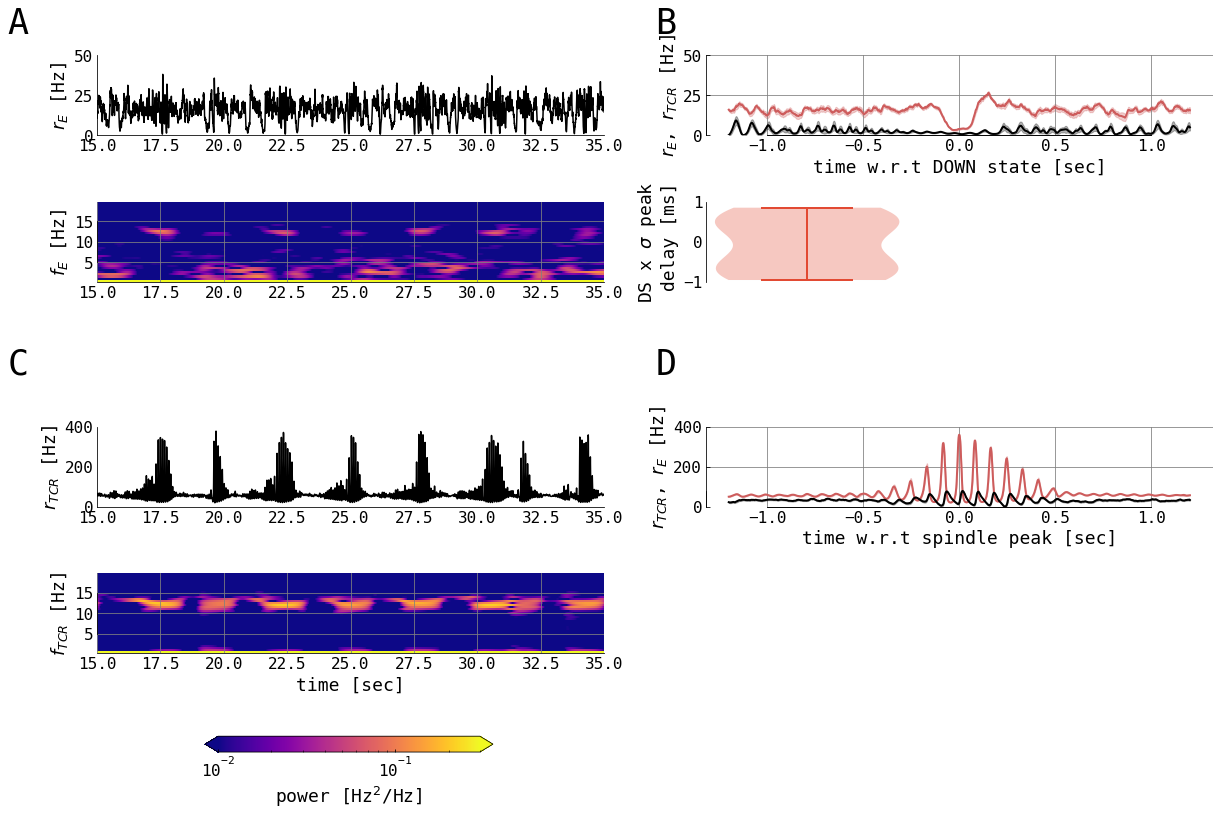

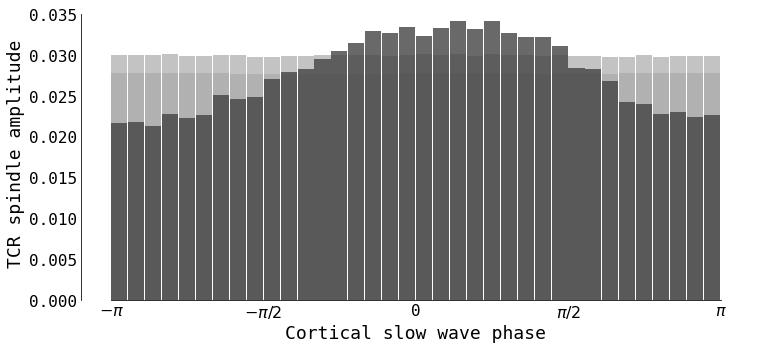

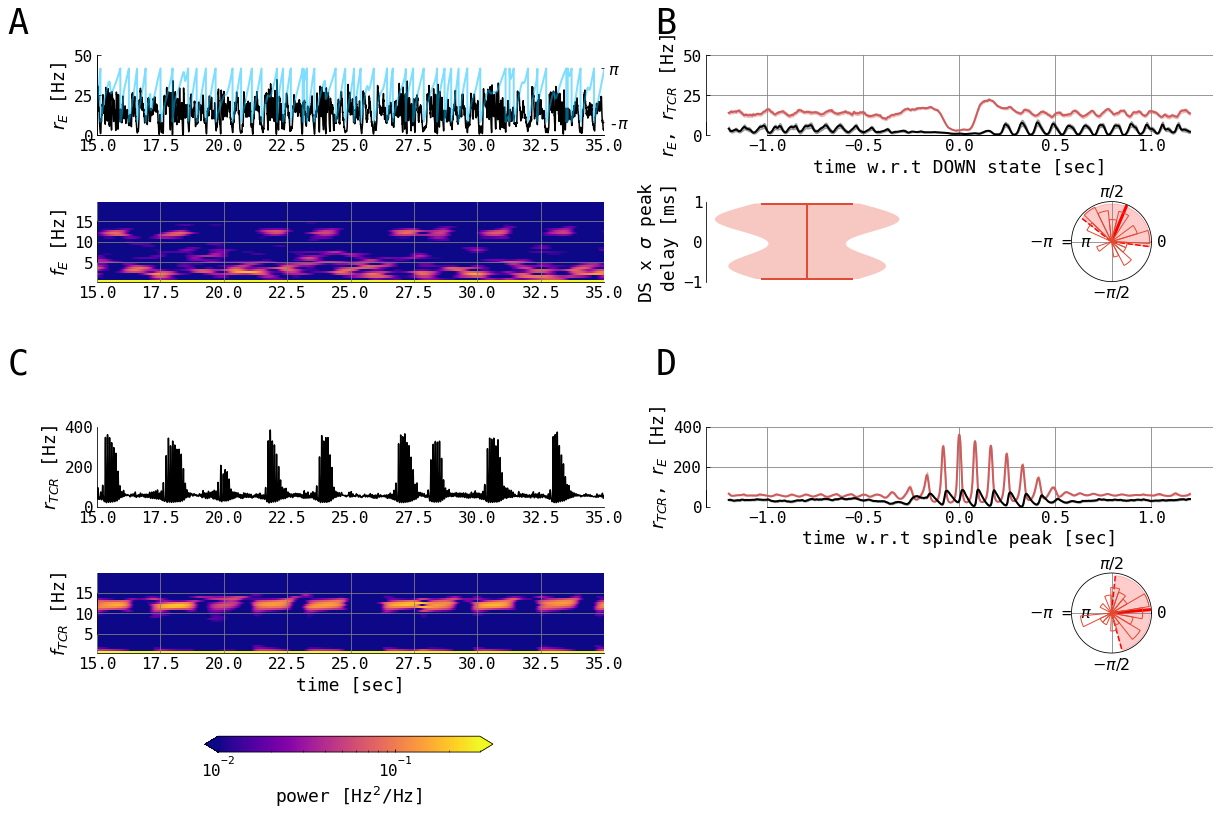

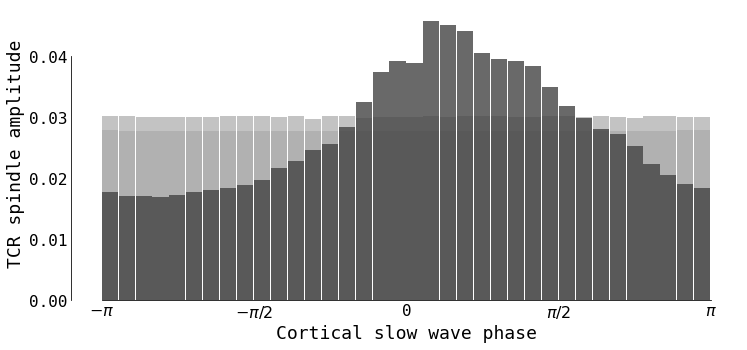

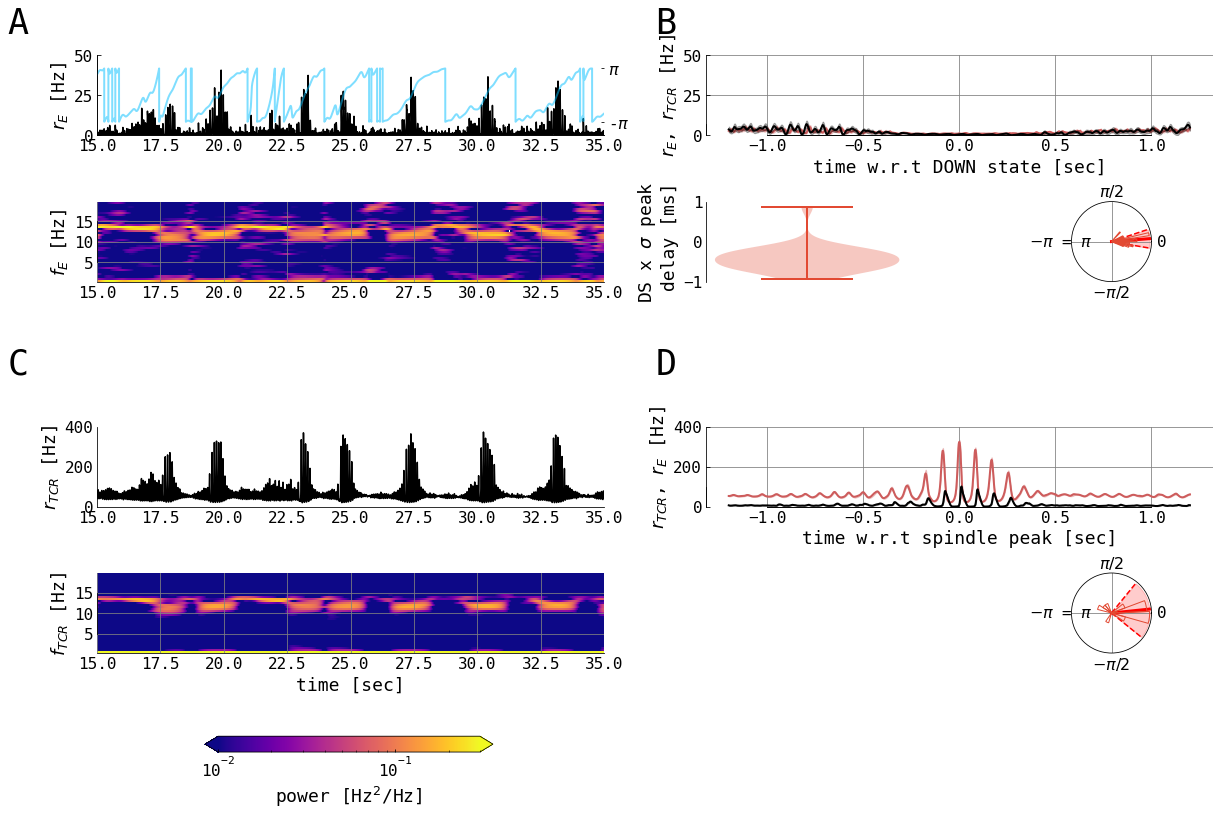

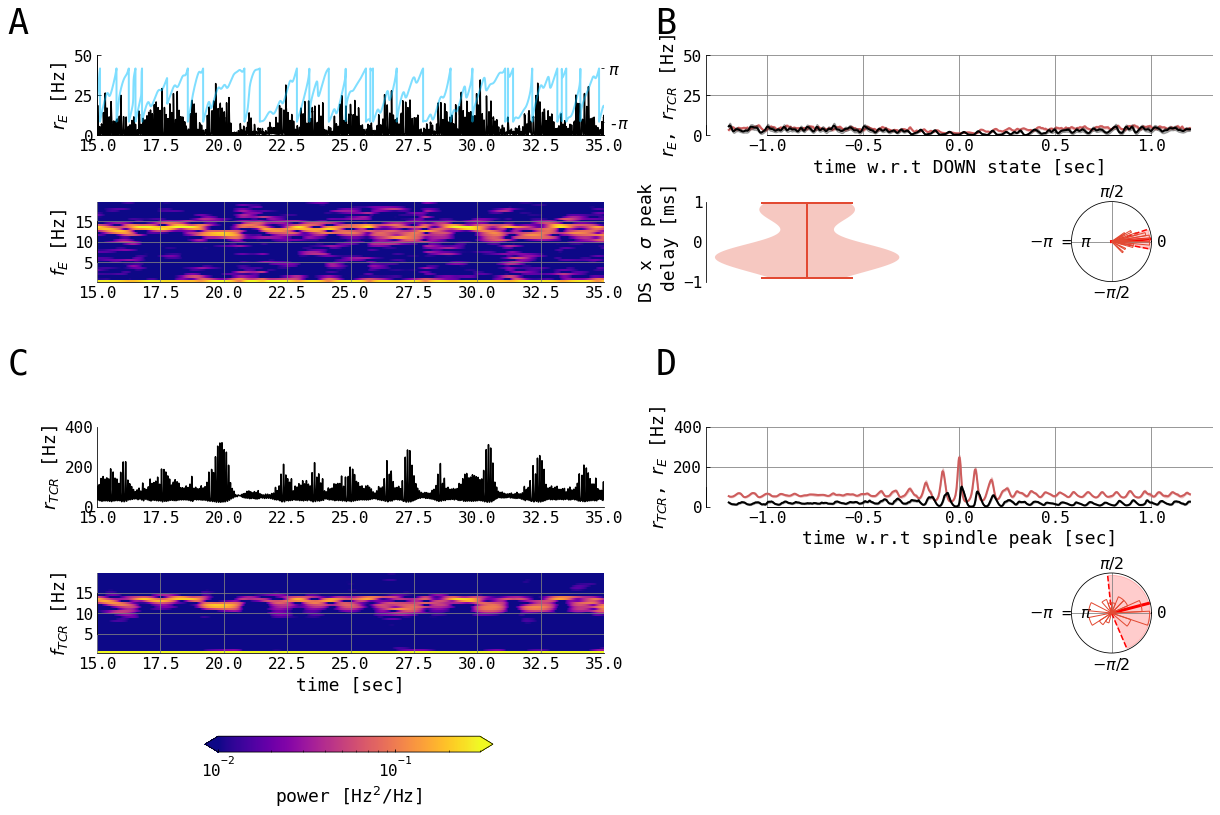

In [4]:
COMPUTE_CFC = True

points = [
    Point(
        name_short="right_border_long",
        name_full=r"Border $\mathregular{{LC_{{aE}}}}$ $\times$ up: long UP states",
        exc_inp=3.2,
        ad_th=1.2,
        th_ad=0.12,
        baseline_exc_inp=3.76,
    ),
    Point(
        name_short="right_border_short",
        name_full=r"Border $\mathregular{{LC_{{aE}}}}$ $\times$ up: short UP states",
        exc_inp=3.05,
        ad_th=1.2,
        th_ad=0.12,
        baseline_exc_inp=3.45,
    ),
    Point(
        name_short="left_border",
        name_full=r"Border down $\times$ $\mathregular{{LC_{{aE}}}}$",
        exc_inp=1.9,
        ad_th=1.2,
        th_ad=0.12,
        baseline_exc_inp=3.1,
    ),
    Point(
        name_short="inside_lc",
        name_full="Inside $\mathregular{{LC_{{aE}}}}$",
        exc_inp=2.15,
        ad_th=1.2,
        th_ad=0.12,
        baseline_exc_inp=3.25,
    ),
]

# prepare
SPINDLE_DURATION = (0.15, 2.0)
REL_POWER_ALN = 0.05
BEFORE_TCR = 1.2
AFTER_TCR = 1.2
BEFORE_SO = 1.2
AFTER_SO = 1.2

# add small constant to Sxx to avoid NaN after log-normalization
SXX_EPS = 1.1e-3

# thresholds and min. DS length based on parametrization
DS_DETECT_VALUES = {
    "right_border_long": [8.0, 0.12],
    "right_border_short": [8.0, 0.12],
    "left_border": [5.0, 0.5],
    "inside_lc": [5.0, 0.2],
}

modes = ["regular"]

cfc_df = pd.DataFrame([])

for mode in modes:
    for point in points:
        if not COMPUTE_CFC and mode == "baseline":
            continue
        print(f" ======= {mode} // {point.name_short} ======= ")

        if "right_border_long" in point.name_short:
            simple_plot = True
        else:
            simple_plot = False

        # simulate network - regular vs baseline
        exc_inp = point.exc_inp if mode == "regular" else point.baseline_exc_inp
        ad_th = point.ad_th if mode == "regular" else 0.0
        th_ad = point.th_ad if mode == "regular" else 0.0
        results_df = simulate_net(
            ad_th=ad_th,
            th_ad=th_ad,
            ou_exc_mu=exc_inp,
            ou_inh_mu=point.inh_inp,
            aln_sigma=0.05,
            tcr_sigma=0.005,
            tauA=1000.0,
            b=15.0,
            a=0.0,
        )

        aln_xr = xr.DataArray(results_df["ALN"])
        tcr_xr = xr.DataArray(results_df["TCR"])
        aln_sig = RatesSignal(aln_xr)
        tcr_sig = RatesSignal(tcr_xr)

        if mode == "regular" or mode == "baseline":
            fig = plt.figure(figsize=(20, 11))
            gs = fig.add_gridspec(nrows=5, ncols=4, height_ratios=[1, 1, 0.15, 1, 1])
            gs.update(wspace=0.5, hspace=1.0)

            # timeseries plot ALN
            ax1 = fig.add_subplot(gs[0, :2])
            ax1.plot(
                results_df.index, results_df["ALN"], color="k", linewidth=1.5, zorder=10
            )
            aln_spindles = spindles_detect_aln(
                xr.DataArray(results_df["ALN"]),
                duration=SPINDLE_DURATION,
                rel_power=REL_POWER_ALN,
            )
            # if aln_spindles is not None:
            # spindles_highlight = results_df["ALN"] * aln_spindles.get_mask()
            # ax1.fill_between(
            # results_df.index, 0, 50, where=spindles_highlight > 0.0, alpha=0.5
            # )
            ax1.set_ylabel("$r_{E}$ [Hz]")
            ax1.set_ylim([0, 50])
            ax1.set_yticks([0, 25, 50])
            ax1.set_xlim([15, 35])
            sns.despine(trim=True, ax=ax1)

            # timeseries plot TCR
            ax2 = fig.add_subplot(gs[3, :2], sharex=ax1)
            ax2.plot(results_df.index, results_df["TCR"], color="k", linewidth=1.5)
            thal_spindles = spindles_detect_thalamus(
                xr.DataArray(results_df["TCR"]), duration=SPINDLE_DURATION
            )
            ax2.set_ylabel("$r_{TCR}$ [Hz]")
            ax2.set_ylim([0, 400])
            ax2.set_yticks([0, 200, 400])
            ax2.set_xlim([15, 35])
            sns.despine(trim=True, ax=ax2)

            # TFR plot ALN and TCR
            sampling_freq = 1.0 / (results_df.index[1] - results_df.index[0])
            window = 2.0  # seconds
            step = 0.2  # seconds
            freqs_bounds = (0.1, 20.0)
            vmin = 0.01
            vmax = 0.3
            for ii, node in enumerate(["ALN", "TCR"]):
                f, _, Sxx = stft_power(
                    results_df[node],
                    sampling_freq,
                    window=window,
                    step=step,
                    band=freqs_bounds,
                    norm=True,
                    interp=True,
                )
                ax = fig.add_subplot(gs[3 * ii + 1, :2], sharex=ax1)
                ax.pcolormesh(
                    results_df.index,
                    f,
                    Sxx + SXX_EPS,
                    cmap=CMAP,
                    rasterized=True,
                    norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax),
                )
                ax.grid()
                ax.set_ylabel(f"$f_{{{'TCR' if node == 'TCR' else 'E'}}}$ [Hz]")
                sns.despine(trim=True, ax=ax)
                ax.set_xlim([15, 35])
            ax.set_xlabel("time [sec]")
            cbar_ax = fig.add_axes([0.2, 0.0, 0.2, 0.02])
            cbar = mpl.colorbar.ColorbarBase(
                cbar_ax,
                cmap=plt.get_cmap(CMAP),
                norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax),
                orientation="horizontal",
                extend="both",
            )
            cbar.set_label("power [Hz$^{2}$/Hz]")

            aln_down_states = dummy_detect_down_states(
                aln_sig,
                threshold=DS_DETECT_VALUES[point.name_short][0],
                min_down_length=DS_DETECT_VALUES[point.name_short][1],
            )
            print(len(aln_down_states))
            ds_midpoints = np.array([ds[len(ds) // 2] for ds in aln_down_states])
            aln_ds_idx, _ = get_centered_indices(
                aln_sig.data.values,
                ds_midpoints,
                int(BEFORE_SO * aln_sig.sampling_frequency),
                int(AFTER_SO * aln_sig.sampling_frequency),
            )

            # locked on ALN down states
            ax3 = fig.add_subplot(gs[0, 2:])
            plot_average_events_ts(
                aln_xr,
                events_idx=aln_ds_idx,
                time_before=BEFORE_SO,
                time_after=AFTER_SO,
                plus_minus_stats="sem",
                color="indianred",
                ylabel="",
                title="",
                second_ts=tcr_xr,
                color_second_ts="k",
                ax=ax3,
            )
            ax3.set_title("")
            ax3.set_ylabel("$r_{E}$, $r_{TCR}$ [Hz]")
            ax3.set_xlabel("time w.r.t DOWN state [sec]")
            ax3.set_ylim(ax1.get_ylim())
            sns.despine(trim=True, ax=ax3)
            sns.despine(trim=True, ax=plt.gca())
            plt.gca().set_yticks([])

            # spindle stats
            aln_so_phase = so_phase(aln_sig)
            # aln_so_phase = get_dummy_so_phase(aln_sig, threshold=2.0, min_down_length=0.1)
            if not simple_plot:
                ax_phase = ax1.twinx()
                ax_phase.plot(
                    results_df.index, aln_so_phase.data.values, color="deepskyblue", alpha=0.5
                )
                ax_phase.set_ylim([-1.5 * np.pi, 1.5 * np.pi])
                ax_phase.set_yticks([-np.pi, np.pi])
                ax_phase.set_yticklabels(["-$\pi$", "$\pi$"])
                sns.despine(ax=ax_phase)
            if aln_spindles is not None:
                # isi = (
                #     aln_spindles.summary().shift(-1)["Start"]
                #     - aln_spindles.summary()["End"]
                # ).dropna()
                # ax5 = fig.add_subplot(gs[1, 2])
                # ax5.hist(isi, bins=15, color="k", rwidth=0.9)
                # sns.despine(ax=ax5)
                # ax5.set_xlabel("ISI [sec]")
                # ax5.set_yticks([])

                aln_sp_amp = get_amplitude(aln_sig, filter_args=SP, pad=5.0)
                so_phases = so_phase_while_spindle(
                    aln_so_phase.data.values, aln_sp_amp.data.values, ds_midpoints
                )
                # so_phases = event_based_so_phase_while_spindle(
                #     aln_so_phase.data.values,
                #     aln_sp_amp.data.values,
                #     ds_midpoints,
                #     sf=aln_sig.sampling_frequency,
                #     event_length=1.0,
                # )
                ax8 = fig.add_subplot(gs[1, 2])
                delays = ds_spindle_coupling(
                    results_df, DS_DETECT_VALUES[point.name_short]
                )
                ax8.violinplot(delays)
                sns.despine(ax=ax8, bottom=True)
                ax8.set_xticks([])
                ax8.set_ylim([-1.0, 1.0])
                ax8.set_ylabel("DS x $\sigma$ peak \n delay [ms]")
                if not simple_plot:
                    ax7 = fig.add_subplot(gs[1, 3], projection="polar")
                    if len(so_phases) > 10:
                        plot_circular_histogram(so_phases, ax=ax7)

            # average spindle TCR
            tcr_idx, _ = get_centered_indices(
                tcr_xr.values,
                (thal_spindles.summary()["Peak"] * tcr_sig.sampling_frequency)
                .astype(int)
                .to_numpy(),
                int(BEFORE_TCR * tcr_sig.sampling_frequency),
                int(AFTER_TCR * tcr_sig.sampling_frequency),
            )
            ax4 = fig.add_subplot(gs[3, 2:])
            plot_average_events_ts(
                tcr_xr,
                events_idx=tcr_idx,
                time_before=BEFORE_TCR,
                time_after=AFTER_TCR,
                plus_minus_stats="sem",
                color="indianred",
                ylabel="",
                title="",
                second_ts=aln_xr,
                color_second_ts="k",
                ax=ax4,
            )
            ax4.set_title("")
            ax4.set_ylabel("$r_{TCR}$, $r_{E}$ [Hz]")
            ax4.set_xlabel("time w.r.t spindle peak [sec]")
            ax4.set_ylim([0, 400])
            sns.despine(trim=True, ax=ax4)
            sns.despine(trim=True, ax=plt.gca())
            plt.gca().set_yticks([])

            # spindle stats
            # isi = (
            #     thal_spindles.summary().shift(-1)["Start"]
            #     - thal_spindles.summary()["End"]
            # ).dropna()
            # ax6 = fig.add_subplot(gs[4, 2])
            # ax6.hist(isi, bins=15, color="k", rwidth=0.9)
            # sns.despine(ax=ax6)
            # ax6.set_xlabel("ISI [sec]")
            # ax6.set_yticks([])
            tcr_sp_amp = get_amplitude(tcr_sig, filter_args=SP, pad=5.0)
            tcr_so_phases = so_phase_while_spindle(
                aln_so_phase.data.values, tcr_sp_amp.data.values, ds_midpoints
            )
            # tcr_so_phases = event_based_so_phase_while_spindle(
            #     aln_so_phase.data.values,
            #     tcr_sp_amp.data.values,
            #     ds_midpoints,
            #     sf=aln_sig.sampling_frequency,
            #     event_length=1.0,
            # )
            if not simple_plot:
                ax9 = fig.add_subplot(gs[4, 3], projection="polar")
                if len(tcr_so_phases) > 10:
                    plot_circular_histogram(tcr_so_phases, ax=ax9)
                else:
                    print(len(tcr_so_phases))

            # plt.suptitle(
            #     r"$\tau_{A}=$"
            #     + f"${point.tauA}$"
            #     + f"\n$\mu_{{E}}={exc_inp / 5.0:.3f}$ nA, $\mu_{{I}}={3.5 / 5.0:.3f}$ nA",
            # )

            plt.text(
                0.07,
                0.92,
                "A",
                ha="center",
                va="center",
                transform=fig.transFigure,
                fontsize=35,
            )
            plt.text(
                0.52,
                0.92,
                "B",
                ha="center",
                va="center",
                transform=fig.transFigure,
                fontsize=35,
            )
            plt.text(
                0.07,
                0.49,
                "C",
                ha="center",
                va="center",
                transform=fig.transFigure,
                fontsize=35,
            )
            plt.text(
                0.52,
                0.49,
                "D",
                ha="center",
                va="center",
                transform=fig.transFigure,
                fontsize=35,
            )

            # to PDF due transparency
            if SAVE_FIG:
                plt.savefig(
                    f"../figs/loop_spindles_{point.name_short}_{mode}.pdf",
                    transparent=True,
                    bbox_inches="tight",
                )
            else:
                plt.show()

        if COMPUTE_CFC and ("right_border" in point.name_short):
            # phase-amplitude CFC
            plt.rcParams["figure.figsize"] = (12, 5.4)
            klmi_data, klmi_surrs, df = klmi_eval(
                aln_sig, tcr_sig, subtype="ALN vs TCR", baseline=mode
            )
            df["param."] = point.name_short
            cfc_df = pd.concat([cfc_df, df], axis=0)
            plot_kullback_leibler_modulation_index(
                klmi_data,
                klmi_surrs,
                data_color="#444444",
                surr_color="#AAAAAA",
                perc_color="#AAAAAA",
            )
            sns.despine(trim=True)
            plt.gca().set_xlabel("Cortical slow wave phase")
            plt.gca().set_ylabel("TCR spindle amplitude")
            plt.gca().set_title("")
            if mode == "regular" and SAVE_FIG:
                plt.savefig(
                    f"../figs/KLMI_aln_tcr_{point.name_short}.pdf",
                    transparent=True,
                    bbox_inches="tight",
                )

            df = mvl_eval(aln_sig, tcr_sig, subtype="ALN vs TCR", baseline=mode)
            df["param."] = point.name_short
            cfc_df = pd.concat([cfc_df, df], axis=0)

            # klmi_data, klmi_surrs, df = klmi_eval(
            #     aln_sig, aln_sig, subtype="ALN vs ALN", baseline=mode
            # )
            # df["param."] = point.name_short
            # cfc_df = pd.concat([cfc_df, df], axis=0)
            # plot_kullback_leibler_modulation_index(
            #     klmi_data,
            #     klmi_surrs,
            #     data_color="#444444",
            #     surr_color="#AAAAAA",
            #     perc_color="#AAAAAA",
            # )
            # sns.despine(trim=True)
            # plt.gca().set_xlabel("ALN slow wave phase")
            # plt.gca().set_ylabel("ALN spindle amplitude")
            # plt.gca().set_title("")
            # if mode == "regular" and SAVE_FIG:
            #     plt.savefig(
            #         f"../figs/KLMI_aln_aln_{point.name_short}.pdf",
            #         transparent=True,
            #         bbox_inches="tight",
            #     )

            # df = mvl_eval(aln_sig, aln_sig, subtype="ALN vs ALN", baseline=mode)
            # df["param."] = point.name_short
            # cfc_df = pd.concat([cfc_df, df], axis=0)

            # phase-phase CFC
            df = plv_eval(aln_sig, tcr_sig, subtype="ALN vs TCR", baseline=mode)
            df["param."] = point.name_short
            cfc_df = pd.concat([cfc_df, df], axis=0)
            df = mi_eval(aln_sig, tcr_sig, subtype="ALN vs TCR", baseline=mode)
            df["param."] = point.name_short
            cfc_df = pd.concat([cfc_df, df], axis=0)

            # df = plv_eval(aln_sig, aln_sig, subtype="ALN vs ALN", baseline=mode)
            # df["param."] = point.name_short
            # cfc_df = pd.concat([cfc_df, df], axis=0)
            # df = mi_eval(aln_sig, aln_sig, subtype="ALN vs ALN", baseline=mode)
            # df["param."] = point.name_short
            # cfc_df = pd.concat([cfc_df, df], axis=0)
    if COMPUTE_CFC:
        cfc_df.to_csv(f"data/results/CFC.csv", index=False)
display(cfc_df)